In [1]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, percentileofscore

import tensorflow as tf
import keras
from keras import layers, models, optimizers
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

DATA_PATH = "big_dataset_lfw"
ORIGINALS_PATH = "images"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

# Recharger les datasets
train_ds = keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="training", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)
val_ds = keras.utils.image_dataset_from_directory(
    DATA_PATH, validation_split=0.2, subset="validation", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical'
)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Reconstruire l'architecture
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.load_weights("mobilenetv2_weights.weights.h5")
dummy = tf.zeros((1, 224, 224, 3))
_ = model(dummy)

print(f"✅ Modèle cible chargé — Classes : {class_names}")

Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.



C:\Users\marwa\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Modèle cible chargé — Classes : ['01_02', '03_04', '05_06', '07_08', '09_10']


In [2]:
# ============================================================
# BLOC 1 : EXTRACTEUR + SCALED CONFIDENCE SCORE (méthode IMIA)
#
# Le "scaled confidence score" est le signal clé de l'IMIA.
# Il mesure l'écart entre la confiance sur la BONNE classe
# et la confiance sur la MEILLEURE mauvaise classe.
# Score élevé → le modèle est très sûr → probable membre
# ============================================================

def extract_features(images):
    """Embeddings 1280-dim via base_model."""
    x = preprocess_input(tf.identity(images))
    x = base_model(x, training=False)
    x = tf.reduce_max(x, axis=[1, 2])
    return x

test_emb = extract_features(tf.zeros((1, 224, 224, 3)))
print(f"✅ Feature extractor OK — Shape : {test_emb.shape}")


def scaled_confidence_score(probs, true_label):
    """
    Calcule le scaled confidence score de l'IMIA (USENIX Sec'26).
    φ(f(x)_y) = log(f(x)_y) - log(max_{y'≠y} f(x)_{y'})
    
    Args:
        probs: vecteur softmax (5-dim)
        true_label: index de la vraie classe (int)
    Returns:
        float: scaled confidence score
    """
    probs = np.clip(probs, 1e-10, 1.0)  # Éviter log(0)
    correct_prob = probs[true_label]
    # Max prob parmi les AUTRES classes
    other_probs = np.concatenate([probs[:true_label], probs[true_label+1:]])
    max_other = np.max(other_probs)
    return np.log(correct_prob) - np.log(max_other)


def extract_imia_signals(image_paths, target_model):
    """
    Extrait les signaux IMIA pour chaque image :
    - embedding (1280-dim)
    - scaled confidence score
    - vecteur softmax
    - label prédit + entropie
    """
    embeddings = []
    scaled_scores = []
    confidences = []
    entropies = []
    predicted_labels = []
    
    for i, path in enumerate(image_paths):
        if i % 50 == 0:
            print(f"  → {i}/{len(image_paths)}...")
        
        img = keras.utils.load_img(path, target_size=(224, 224))
        img_array = tf.expand_dims(keras.utils.img_to_array(img), 0)
        
        # Embedding
        emb = extract_features(img_array)
        embeddings.append(emb.numpy().flatten())
        
        # Softmax
        conf = target_model.predict(img_array, verbose=0).flatten()
        confidences.append(conf)
        
        # Label prédit (argmax)
        pred_label = np.argmax(conf)
        predicted_labels.append(pred_label)
        
        # SCALED CONFIDENCE SCORE (signal IMIA)
        sc = scaled_confidence_score(conf, pred_label)
        scaled_scores.append(sc)
        
        # Entropie
        entropies.append(entropy(conf))
    
    print(f"  → {len(image_paths)}/{len(image_paths)} ✓")
    return {
        'embeddings': np.array(embeddings),
        'scaled_scores': np.array(scaled_scores),
        'confidences': np.array(confidences),
        'entropies': np.array(entropies),
        'predicted_labels': np.array(predicted_labels)
    }

print("✅ Fonctions IMIA définies (scaled confidence score)")

✅ Feature extractor OK — Shape : (1, 1280)
✅ Fonctions IMIA définies (scaled confidence score)


In [3]:
# ============================================================
# BLOC 2 : SPLIT MEMBRE / NON-MEMBRE + EXTRACTION SIGNAUX IMIA
# ============================================================

all_paths = sorted(glob.glob(os.path.join(DATA_PATH, "**", "*.png"), recursive=True))
print(f"Total images : {len(all_paths)}")

# Reproduire le split train/val (seed=123, 80/20)
np.random.seed(123)
indices = np.random.permutation(len(all_paths))
split_idx = int(0.8 * len(all_paths))

member_paths = [all_paths[i] for i in indices[:split_idx]]
nonmember_paths = [all_paths[i] for i in indices[split_idx:]]

# Sous-échantillonner
MAX_SAMPLES = 200
random.seed(42)
if len(member_paths) > MAX_SAMPLES:
    member_paths = random.sample(member_paths, MAX_SAMPLES)
if len(nonmember_paths) > MAX_SAMPLES:
    nonmember_paths = random.sample(nonmember_paths, MAX_SAMPLES)

print(f"Membres (train)     : {len(member_paths)}")
print(f"Non-membres (val)   : {len(nonmember_paths)}")

print("\nExtraction IMIA pour les MEMBRES...")
member_signals = extract_imia_signals(member_paths, model)

print("\nExtraction IMIA pour les NON-MEMBRES...")
nonmember_signals = extract_imia_signals(nonmember_paths, model)

# Aperçu des scores
print(f"\n✅ Scaled confidence score moyen :")
print(f"   Membres     : {member_signals['scaled_scores'].mean():.4f}")
print(f"   Non-membres : {nonmember_signals['scaled_scores'].mean():.4f}")

Total images : 2000
Membres (train)     : 200
Non-membres (val)   : 200

Extraction IMIA pour les MEMBRES...
  → 0/200...
  → 50/200...
  → 100/200...
  → 150/200...
  → 200/200 ✓

Extraction IMIA pour les NON-MEMBRES...
  → 0/200...
  → 50/200...
  → 100/200...
  → 150/200...
  → 200/200 ✓

✅ Scaled confidence score moyen :
   Membres     : 3.5532
   Non-membres : 3.1756


In [4]:
# ============================================================
# BLOC 3 : IMITATIVE TRAINING (méthode IMIA, USENIX Sec'26)
#
# Étape 1 : Imitative OUT model
#   → Entraîné à IMITER les outputs du target sur des données
#     que le target n'a PAS vues (= non-membres)
#   → Capture le comportement du target sur les non-membres
#
# Étape 2 : Pivot Selection
#   → Sélectionner les k images/classe avec la LOSS la plus
#     basse sur le target (= probablement mémorisées)
#
# Étape 3 : Imitative IN model
#   → Fine-tuner le OUT model sur les pivots
#   → Capture le comportement du target sur les membres
# ============================================================

N_IMITATE = 3  # Nombre de paires (IN, OUT) — paper recommande 10-64

# --- Architecture de base pour les modèles imitatifs ---
def build_imitative_model():
    imi_base = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    imi_base.trainable = False
    
    imi_model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Lambda(preprocess_input),
        imi_base,
        layers.GlobalMaxPooling2D(),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return imi_model

# --- Imitation Loss : MSE entre softmax du target et softmax du imitatif ---
# (Le paper utilise une loss custom, on approxime avec MSE sur les logits)

# Préparer les données d'imitation avec les OUTPUTS du target
print("Préparation des données d'imitation...")

# Données pour OUT : validation set (non vues par le target)
imi_out_images = []
imi_out_targets = []  # = outputs du TARGET (pas les vrais labels!)
for imgs, _ in val_ds:
    target_preds = model.predict(imgs, verbose=0)  # Outputs du target
    imi_out_images.append(imgs.numpy())
    imi_out_targets.append(target_preds)
imi_out_images = np.vstack(imi_out_images)
imi_out_targets = np.vstack(imi_out_targets)
print(f"  Données OUT : {len(imi_out_images)} images")

# Données pour IN (pivot) : images du train avec la loss la plus basse
print("Sélection des pivots (images les plus mémorisées)...")
pivot_images = []
pivot_targets = []
all_losses = []
all_imgs_train = []
all_preds_train = []

for imgs, labels in train_ds:
    preds = model.predict(imgs, verbose=0)
    # Loss par image
    losses = -np.sum(labels.numpy() * np.log(np.clip(preds, 1e-10, 1.0)), axis=1)
    all_losses.extend(losses)
    all_imgs_train.append(imgs.numpy())
    all_preds_train.append(preds)

all_losses = np.array(all_losses)
all_imgs_train = np.vstack(all_imgs_train)
all_preds_train = np.vstack(all_preds_train)

# Sélectionner les k=50 images avec la loss la plus BASSE par classe
K_PIVOTS = 50
pred_classes = np.argmax(all_preds_train, axis=1)
pivot_indices = []
for c in range(NUM_CLASSES):
    class_mask = pred_classes == c
    class_indices = np.where(class_mask)[0]
    class_losses = all_losses[class_indices]
    # Les k avec la loss la plus basse = les plus mémorisées
    top_k = class_indices[np.argsort(class_losses)[:K_PIVOTS]]
    pivot_indices.extend(top_k)

pivot_images = all_imgs_train[pivot_indices]
pivot_targets = all_preds_train[pivot_indices]  # Targets = outputs du modèle cible
print(f"  Pivots sélectionnés : {len(pivot_images)} images")

# --- Entraîner N paires (OUT, IN) ---
print(f"\nEntraînement de {N_IMITATE} paires de modèles imitatifs...")
imitative_out_models = []
imitative_in_models = []

for n in range(N_IMITATE):
    print(f"\n--- Paire {n+1}/{N_IMITATE} ---")
    
    # Phase 1 : Imitative OUT (imite le target sur les non-membres)
    imi_out = build_imitative_model()
    imi_out.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    
    # Shuffle les données OUT
    shuffle_idx = np.random.permutation(len(imi_out_images))
    X_out = imi_out_images[shuffle_idx[:300]]  # Sous-ensemble aléatoire
    Y_out = imi_out_targets[shuffle_idx[:300]]
    
    print(f"  Phase 1 (OUT) : imitation sur {len(X_out)} non-membres...")
    imi_out.fit(X_out, Y_out, epochs=5, batch_size=32, verbose=0)
    imitative_out_models.append(imi_out)
    
    # Phase 2 : Imitative IN = fine-tune OUT sur les pivots
    imi_in = build_imitative_model()
    imi_in.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    # Copier les poids du OUT
    imi_in.set_weights(imi_out.get_weights())
    # Fine-tune sur les pivots
    imi_in.compile(optimizer=optimizers.Adam(1e-4), loss='mse')
    
    print(f"  Phase 2 (IN)  : fine-tune sur {len(pivot_images)} pivots...")
    imi_in.fit(pivot_images, pivot_targets, epochs=3, batch_size=32, verbose=0)
    imitative_in_models.append(imi_in)

print(f"\n✅ {N_IMITATE} paires (OUT, IN) entraînées")

Préparation des données d'imitation...
  Données OUT : 400 images
Sélection des pivots (images les plus mémorisées)...
  Pivots sélectionnés : 250 images

Entraînement de 3 paires de modèles imitatifs...

--- Paire 1/3 ---
  Phase 1 (OUT) : imitation sur 300 non-membres...
  Phase 2 (IN)  : fine-tune sur 250 pivots...

--- Paire 2/3 ---
  Phase 1 (OUT) : imitation sur 300 non-membres...
  Phase 2 (IN)  : fine-tune sur 250 pivots...

--- Paire 3/3 ---
  Phase 1 (OUT) : imitation sur 300 non-membres...
  Phase 2 (IN)  : fine-tune sur 250 pivots...

✅ 3 paires (OUT, IN) entraînées


In [5]:
# ============================================================
# BLOC 4 : SCORING IMIA NON-PARAMÉTRIQUE
#
# Pour chaque query (x, y), on calcule :
#   - S_out = {φ(f_out(x)_y)} pour chaque modèle OUT
#   - S_in  = {φ(f_in(x)_y)}  pour chaque modèle IN
#   - Score IMIA = mean(S_in) - mean(S_out)
#
# Si score > 0 : le modèle se comporte comme s'il avait
# vu cette donnée → probable membre
# ============================================================

def compute_imia_score(image_path, target_model, out_models, in_models):
    """Calcule le score IMIA pour une seule image."""
    img = keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.expand_dims(keras.utils.img_to_array(img), 0)
    
    # Label prédit par le target
    target_conf = target_model.predict(img_array, verbose=0).flatten()
    pred_label = np.argmax(target_conf)
    
    # Score du target
    target_sc = scaled_confidence_score(target_conf, pred_label)
    
    # Scores OUT
    s_out = []
    for m_out in out_models:
        conf = m_out.predict(img_array, verbose=0).flatten()
        s_out.append(scaled_confidence_score(conf, pred_label))
    
    # Scores IN
    s_in = []
    for m_in in in_models:
        conf = m_in.predict(img_array, verbose=0).flatten()
        s_in.append(scaled_confidence_score(conf, pred_label))
    
    # Score IMIA = différence IN vs OUT
    imia_score = np.mean(s_in) - np.mean(s_out)
    
    return {
        'imia_score': imia_score,
        'target_score': target_sc,
        'mean_in': np.mean(s_in),
        'mean_out': np.mean(s_out)
    }


# --- Calcul sur membres et non-membres ---
print("Calcul des scores IMIA sur les MEMBRES...")
member_imia_scores = []
for i, path in enumerate(member_paths):
    if i % 50 == 0:
        print(f"  → {i}/{len(member_paths)}...")
    result = compute_imia_score(path, model, imitative_out_models, imitative_in_models)
    member_imia_scores.append(result)

print("\nCalcul des scores IMIA sur les NON-MEMBRES...")
nonmember_imia_scores = []
for i, path in enumerate(nonmember_paths):
    if i % 50 == 0:
        print(f"  → {i}/{len(nonmember_paths)}...")
    result = compute_imia_score(path, model, imitative_out_models, imitative_in_models)
    nonmember_imia_scores.append(result)

# Extraire les scores
m_scores = np.array([r['imia_score'] for r in member_imia_scores])
nm_scores = np.array([r['imia_score'] for r in nonmember_imia_scores])

print(f"\n✅ Scores IMIA calculés")
print(f"   Score moyen MEMBRES     : {m_scores.mean():.4f} ± {m_scores.std():.4f}")
print(f"   Score moyen NON-MEMBRES : {nm_scores.mean():.4f} ± {nm_scores.std():.4f}")
print(f"   Δ (IN - OUT gap)        : {m_scores.mean() - nm_scores.mean():.4f}")

Calcul des scores IMIA sur les MEMBRES...
  → 0/200...
  → 50/200...
  → 100/200...
  → 150/200...

Calcul des scores IMIA sur les NON-MEMBRES...
  → 0/200...
  → 50/200...
  → 100/200...
  → 150/200...

✅ Scores IMIA calculés
   Score moyen MEMBRES     : 1.1337 ± 2.4431
   Score moyen NON-MEMBRES : 0.9587 ± 2.6543
   Δ (IN - OUT gap)        : 0.1749


In [6]:
# ============================================================
# BLOC 5 : ÉVALUATION — AUC-ROC + TPR@low FPR
# Le paper IMIA met l'accent sur le TPR à faible FPR
# (plus réaliste qu'un AUC global)
# ============================================================
from sklearn.metrics import roc_auc_score, roc_curve

all_scores = np.concatenate([m_scores, nm_scores])
all_labels = np.concatenate([np.ones(len(m_scores)), np.zeros(len(nm_scores))])

# AUC-ROC
auc = roc_auc_score(all_labels, all_scores)
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)

# TPR @ différents FPR (métrique clé du paper IMIA)
target_fprs = [0.01, 0.05, 0.10, 0.20]
tpr_at_fpr = {}
for target_fpr in target_fprs:
    idx = np.argmin(np.abs(fpr - target_fpr))
    tpr_at_fpr[target_fpr] = tpr[idx]

print("=" * 60)
print("        RÉSULTATS IMIA (méthode USENIX Sec'26)")
print("=" * 60)
print(f"  AUC-ROC                    : {auc:.4f}")
for t_fpr, t_tpr in tpr_at_fpr.items():
    print(f"  TPR @ {t_fpr*100:.0f}% FPR             : {t_tpr:.4f}")
print(f"  Score moyen MEMBRES        : {m_scores.mean():.4f}")
print(f"  Score moyen NON-MEMBRES    : {nm_scores.mean():.4f}")
print("=" * 60)

        RÉSULTATS IMIA (méthode USENIX Sec'26)
  AUC-ROC                    : 0.4948
  TPR @ 1% FPR             : 0.0150
  TPR @ 5% FPR             : 0.0700
  TPR @ 10% FPR             : 0.1150
  TPR @ 20% FPR             : 0.2050
  Score moyen MEMBRES        : 1.1337
  Score moyen NON-MEMBRES    : 0.9587


In [7]:
# ============================================================
# BLOC 6 : COMPARAISON DIRECTE ORIGINAUX vs MORPHS
# ============================================================
from sklearn.metrics.pairwise import cosine_similarity

MORPH_MAPPING = {
    "01_02": ["lfw_person_01", "lfw_person_02"],
    "03_04": ["lfw_person_03", "lfw_person_04"],
    "05_06": ["lfw_person_05", "lfw_person_06"],
    "07_08": ["lfw_person_07", "lfw_person_08"],
    "09_10": ["lfw_person_09", "lfw_person_10"],
}

# Extraire embeddings + scaled scores des originaux
print("Extraction des signaux IMIA sur les ORIGINAUX...")
original_data = {}
for person_folder in sorted(os.listdir(ORIGINALS_PATH)):
    person_path = os.path.join(ORIGINALS_PATH, person_folder)
    if not os.path.isdir(person_path):
        continue
    
    imgs_paths = sorted(glob.glob(os.path.join(person_path, "*.png")))[:50]
    embs = []
    scores = []
    for p in imgs_paths:
        img = keras.utils.load_img(p, target_size=(224, 224))
        img_array = tf.expand_dims(keras.utils.img_to_array(img), 0)
        emb = extract_features(img_array)
        embs.append(emb.numpy().flatten())
        conf = model.predict(img_array, verbose=0).flatten()
        sc = scaled_confidence_score(conf, np.argmax(conf))
        scores.append(sc)
    
    original_data[person_folder] = {
        'embeddings': np.array(embs),
        'scaled_scores': np.array(scores)
    }
    print(f"  {person_folder}: {len(embs)} images, score moyen: {np.mean(scores):.4f}")

# Extraire embeddings des morphs
print("\nExtraction des embeddings des MORPHS...")
morph_data = {}
for morph_class in sorted(os.listdir(DATA_PATH)):
    morph_dir = os.path.join(DATA_PATH, morph_class)
    if not os.path.isdir(morph_dir):
        continue
    morph_paths = sorted(glob.glob(os.path.join(morph_dir, "*.png")))[:50]
    embs = []
    for p in morph_paths:
        img = keras.utils.load_img(p, target_size=(224, 224))
        img_array = tf.expand_dims(keras.utils.img_to_array(img), 0)
        emb = extract_features(img_array)
        embs.append(emb.numpy().flatten())
    morph_data[morph_class] = np.array(embs)
    print(f"  {morph_class}: {len(embs)} morphs")

# Similarité LIÉS vs NON-LIÉS
sim_lies = []
sim_non_lies = []

for morph_class, source_persons in MORPH_MAPPING.items():
    if morph_class not in morph_data:
        continue
    m_embs = morph_data[morph_class]
    for person in original_data:
        o_embs = original_data[person]['embeddings']
        avg_sim = cosine_similarity(o_embs, m_embs).mean()
        if person in source_persons:
            sim_lies.append(avg_sim)
        else:
            sim_non_lies.append(avg_sim)

sim_lies = np.array(sim_lies)
sim_non_lies = np.array(sim_non_lies)

print(f"\n{'='*60}")
print(f"  Sim. LIÉS (original→ses morphs)       : {sim_lies.mean():.4f} ± {sim_lies.std():.4f}")
print(f"  Sim. NON-LIÉS (original→autres morphs) : {sim_non_lies.mean():.4f} ± {sim_non_lies.std():.4f}")
print(f"  Δ similarité                           : {sim_lies.mean() - sim_non_lies.mean():.4f}")
print(f"{'='*60}")

Extraction des signaux IMIA sur les ORIGINAUX...
  lfw_person_01: 50 images, score moyen: 2.1787
  lfw_person_02: 50 images, score moyen: 1.7716
  lfw_person_03: 50 images, score moyen: 1.9810
  lfw_person_04: 50 images, score moyen: 1.9915
  lfw_person_05: 50 images, score moyen: 2.0754
  lfw_person_06: 50 images, score moyen: 2.7164
  lfw_person_07: 50 images, score moyen: 2.5377
  lfw_person_08: 50 images, score moyen: 2.7791
  lfw_person_09: 50 images, score moyen: 2.1376
  lfw_person_10: 50 images, score moyen: 1.9347

Extraction des embeddings des MORPHS...
  01_02: 50 morphs
  03_04: 50 morphs
  05_06: 50 morphs
  07_08: 50 morphs
  09_10: 50 morphs

  Sim. LIÉS (original→ses morphs)       : 0.7265 ± 0.0078
  Sim. NON-LIÉS (original→autres morphs) : 0.7225 ± 0.0079
  Δ similarité                           : 0.0040


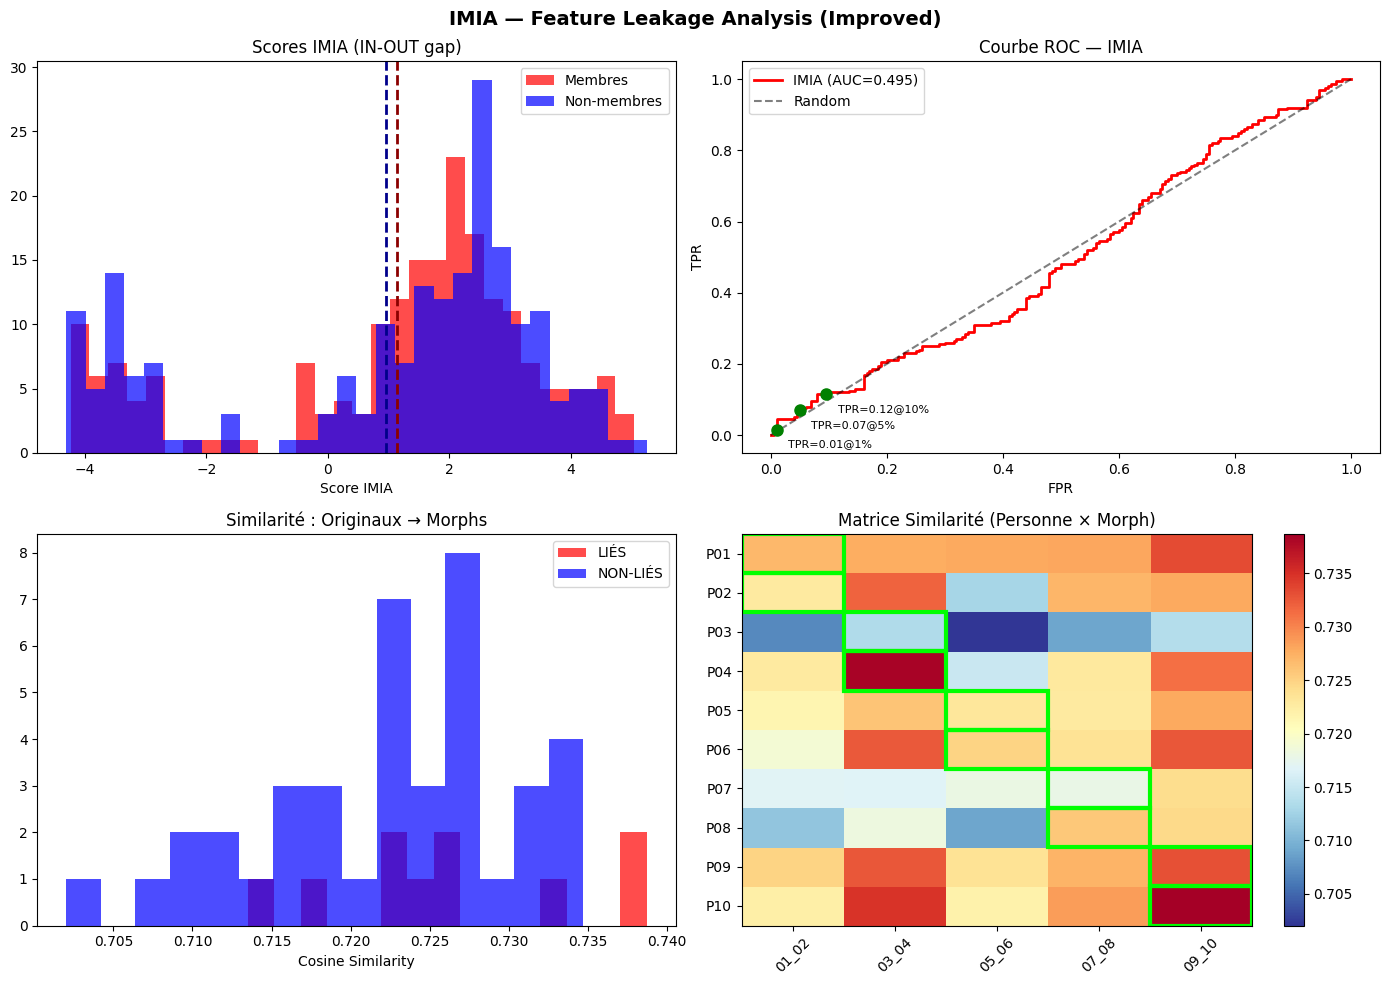

In [8]:
# ============================================================
# BLOC 7 : VISUALISATIONS (4 graphiques)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A. Distribution des scores IMIA (scaled confidence)
axes[0, 0].hist(m_scores, bins=30, alpha=0.7, label='Membres', color='red')
axes[0, 0].hist(nm_scores, bins=30, alpha=0.7, label='Non-membres', color='blue')
axes[0, 0].axvline(m_scores.mean(), color='darkred', linestyle='--', linewidth=2)
axes[0, 0].axvline(nm_scores.mean(), color='darkblue', linestyle='--', linewidth=2)
axes[0, 0].set_title('Scores IMIA (IN-OUT gap)')
axes[0, 0].set_xlabel('Score IMIA')
axes[0, 0].legend()

# B. Courbe ROC
axes[0, 1].plot(fpr, tpr, 'r-', linewidth=2, label=f'IMIA (AUC={auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
for t_fpr in [0.01, 0.05, 0.10]:
    idx = np.argmin(np.abs(fpr - t_fpr))
    axes[0, 1].plot(fpr[idx], tpr[idx], 'go', markersize=8)
    axes[0, 1].annotate(f'TPR={tpr[idx]:.2f}@{t_fpr*100:.0f}%',
                         (fpr[idx]+0.02, tpr[idx]-0.05), fontsize=8)
axes[0, 1].set_title('Courbe ROC — IMIA')
axes[0, 1].set_xlabel('FPR')
axes[0, 1].set_ylabel('TPR')
axes[0, 1].legend()

# C. Similarité Originaux → Morphs (LIÉS vs NON-LIÉS)
axes[1, 0].hist(sim_lies, bins=15, alpha=0.7, label='LIÉS', color='red')
axes[1, 0].hist(sim_non_lies, bins=15, alpha=0.7, label='NON-LIÉS', color='blue')
axes[1, 0].set_title('Similarité : Originaux → Morphs')
axes[1, 0].set_xlabel('Cosine Similarity')
axes[1, 0].legend()

# D. Matrice de similarité Personne × Classe Morph
persons = sorted(original_data.keys())
morph_classes = sorted(morph_data.keys())
sim_matrix = np.zeros((len(persons), len(morph_classes)))
for i, person in enumerate(persons):
    for j, mc in enumerate(morph_classes):
        sim_matrix[i, j] = cosine_similarity(
            original_data[person]['embeddings'], morph_data[mc]).mean()

im = axes[1, 1].imshow(sim_matrix, cmap='RdYlBu_r', aspect='auto')
axes[1, 1].set_xticks(range(len(morph_classes)))
axes[1, 1].set_xticklabels(morph_classes, rotation=45)
axes[1, 1].set_yticks(range(len(persons)))
axes[1, 1].set_yticklabels([p.replace('lfw_person_', 'P') for p in persons])
axes[1, 1].set_title('Matrice Similarité (Personne × Morph)')
plt.colorbar(im, ax=axes[1, 1])
# Encadrer les paires LIÉES
for mc, sources in MORPH_MAPPING.items():
    if mc in morph_classes:
        j = morph_classes.index(mc)
        for src in sources:
            if src in persons:
                i = persons.index(src)
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False,
                                     edgecolor='lime', linewidth=3)
                axes[1, 1].add_patch(rect)

plt.suptitle('IMIA — Feature Leakage Analysis (Improved)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
print("=" * 70)
print("       RAPPORT IMIA COMPLET — USENIX Security'26 Method")
print("=" * 70)
print(f"  Modèle cible           : MobileNetV2 (fine-tuné, {NUM_CLASSES} classes)")
print(f"  Dataset                : {DATA_PATH} ({len(all_paths)} morphs)")
print(f"  Originaux              : {ORIGINALS_PATH} ({len(original_data)} personnes)")
print(f"  Modèles imitatifs      : {N_IMITATE} paires (IN/OUT)")
print("-" * 70)
print("  [1] ATTAQUE IMIA (membership inference)")
print(f"      AUC-ROC            : {auc:.4f}")
for t_fpr, t_tpr in tpr_at_fpr.items():
    print(f"      TPR @ {t_fpr*100:.0f}% FPR      : {t_tpr:.4f}")
print(f"      Score Δ (M - NM)   : {m_scores.mean() - nm_scores.mean():.4f}")
print("-" * 70)
print("  [2] FEATURE LEAKAGE (originaux → morphs)")
print(f"      Sim. LIÉS          : {sim_lies.mean():.4f} ± {sim_lies.std():.4f}")
print(f"      Sim. NON-LIÉS      : {sim_non_lies.mean():.4f} ± {sim_non_lies.std():.4f}")
print(f"      Δ similarité       : {sim_lies.mean() - sim_non_lies.mean():.4f}")
print("-" * 70)

delta_sim = sim_lies.mean() - sim_non_lies.mean()
if auc > 0.7 or delta_sim > 0.05:
    print("  ⚠️  VERDICT : Fuite SIGNIFICATIVE.")
    print("     Le morphing ne protège PAS suffisamment les identités.")
elif auc > 0.6 or delta_sim > 0.02:
    print("  🟡 VERDICT : Fuite MARGINALE.")
    print("     Protection partielle, risque résiduel.")
else:
    print("  ✅ VERDICT : Morphing efficace.")
    print("     Les identités sources sont protégées.")
print("=" * 70)

       RAPPORT IMIA COMPLET — USENIX Security'26 Method
  Modèle cible           : MobileNetV2 (fine-tuné, 5 classes)
  Dataset                : big_dataset_lfw (2000 morphs)
  Originaux              : images (10 personnes)
  Modèles imitatifs      : 3 paires (IN/OUT)
----------------------------------------------------------------------
  [1] ATTAQUE IMIA (membership inference)
      AUC-ROC            : 0.4948
      TPR @ 1% FPR      : 0.0150
      TPR @ 5% FPR      : 0.0700
      TPR @ 10% FPR      : 0.1150
      TPR @ 20% FPR      : 0.2050
      Score Δ (M - NM)   : 0.1749
----------------------------------------------------------------------
  [2] FEATURE LEAKAGE (originaux → morphs)
      Sim. LIÉS          : 0.7265 ± 0.0078
      Sim. NON-LIÉS      : 0.7225 ± 0.0079
      Δ similarité       : 0.0040
----------------------------------------------------------------------
  ✅ VERDICT : Morphing efficace.
     Les identités sources sont protégées.
